In [133]:
# import csv
from glob import glob
from pathlib import Path
from statistics import mean

from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# Milvus parameters
HOST = '127.0.0.1'
PORT = '19530'
TOPK = 10
DIM = 256 # dimension of embedding extracted by MODEL
COLLECTION_NAME = 'reverse_image_search'
INDEX_TYPE = 'FLAT' #'IVF_FLAT'
METRIC_TYPE = 'L2'

## Generar request a Triton

In [74]:
import subprocess
import shutil
import os

def run_tao_inference(output_path, query_path, image_path):
    """
    Runs TAO inference using tao_client.py with specified output path and image path.

    Args:
        output_path (str): Path to save the inference output.
        query_path (str): Path to the query file for inference.
        image_path (str): Path to the image for inference.

    Returns:
        None
    """

    # Clear output directory (if it exists) to avoid conflicts
    if os.path.exists(output_path):
        shutil.rmtree(output_path)  # Use `shutil.rmtree()` for safe directory removal

    # Construct the command with parameters
    command = [
        "python3",
        "./tao_triton/python/entrypoints/tao_client.py",
        query_path,
        "--test_dir",
        image_path,
        "-m", "re_identification_tao",
        "-x", "1",
        "-b", "16",
        "--mode", "Re_identification",
        "-i", "https",
        "-u", "localhost:8000",
        "--async",
        "--output_path", output_path
    ]

    # Execute the command using subprocess.run()
    try:
        subprocess.run(command, check=True)
        print("Comando ejecutado correctamente.")
    except subprocess.CalledProcessError as e:
        print(f"Error al ejecutar el comando: {e}")

In [134]:
# Example usage
output_path = "./Dataset/output_resnet_256x196" #output_resnet50_market1501_aug
query_path = "./Dataset/query"
image_path = "./Dataset/sample_test"

#run_tao_inference(output_path, query_path, image_path)


In [135]:
import json
import re

def extract_camera_number(camera_string):
    match = re.match(r"c(\d+)", camera_string)
    if match:
        return int(match.group(1))
    else:
        return None

def extract_id(image_path):
    # Obtener el nombre base del archivo (sin la extensión)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    # Dividir el nombre base en campos separados por "_"
    fields = base_name.split("_")
    # Obtener el ID de la persona (el primer campo del nombre base)
    person_id = fields[0]
    cam_id=extract_camera_number(fields[1])
    return person_id, cam_id

# Leer el archivo results.json
with open(f"{output_path}/results.json", "r") as results_file:
          results = json.load(results_file)
        
results_id=results.copy()

for i,r in enumerate(results):
    person_id, cam_id=extract_id(r["img_path"])
    #print("Person", person_id)
    d={"id":i, "person_id":person_id, "cam_id":cam_id}
    d.update(r)
    results_id[i]= d 
    # images_paths.append(r["img_path"])
    # embeddings.append(r["embedding"])
    # id.append(i) 

#print(type(results_id[10]['embedding']))
print(results_id[10])

{'id': 10, 'person_id': '0041', 'cam_id': 5, 'img_path': './Dataset/sample_test/0041_c5s3_007623.jpg', 'embedding': [0.338134765625, -0.32373046875, -0.59326171875, -0.44140625, -0.481689453125, 0.9853515625, 0.0310821533203125, 0.798828125, -1.1025390625, 0.41796875, -0.52099609375, -0.46142578125, 0.421875, 0.17529296875, -0.3408203125, 0.233642578125, -0.1131591796875, 0.445556640625, -0.135009765625, -0.8173828125, 0.5078125, -1.2373046875, -0.10821533203125, 0.4228515625, -0.8486328125, 0.1568603515625, 0.0289154052734375, 1.3330078125, 0.57861328125, -0.0137786865234375, -0.6103515625, -0.2413330078125, 0.8408203125, -0.27001953125, -0.2108154296875, -0.54736328125, -1.3193359375, -0.48193359375, 0.50341796875, -0.85546875, -0.98681640625, 0.2186279296875, 0.52099609375, -1.505859375, -0.7412109375, 0.07501220703125, 1.6611328125, 0.16650390625, -0.8740234375, -0.1285400390625, -0.337646484375, 0.04656982421875, -0.374755859375, 0.94140625, -0.464111328125, -1.0146484375, -0.8793

## Cargar los embeddings en una coleccion de Milvus

In [137]:
# Importar módulos necesarios
from pymilvus import connections, FieldSchema, DataType, CollectionSchema, utility, Collection

# Definir función para insertar embeddings en Milvus
def insert_embeddings_to_milvus(results_id, host, port, collection_name):
    # Conectar a Milvus
    connections.connect(host=host, port=port)

    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)

    # Definir esquema de campo
    fields = [
        FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=False),
        FieldSchema(name='person_id', dtype=DataType.VARCHAR, description='person id', max_length=5),
        FieldSchema(name='cam_id', dtype=DataType.INT64, description='cam id'),
        FieldSchema(name='img_path', dtype=DataType.VARCHAR, description='path to image', max_length=500), #is_primary=True, auto_id=False
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=DIM) #256, 768
    ]
    
    # Definir esquema de colección
    schema = CollectionSchema(fields=fields, description="reverse image search")
        
    # Crear índice en el campo de embeddings
    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        #'params': {"nlist": 2048} # Usar para IVY FLAT
    }
    collection = Collection(name=collection_name, schema=schema) 
        
    if collection.has_index():
        # Si existe un índice, eliminarlo
        collection.release()
        collection.drop_index()

    collection.create_index(field_name='embedding', index_params=index_params)
        
    # Insertar embeddings en la colección
    collection.insert(results_id)
        
    print("Embeddings inserted successfully into Milvus collection:", collection_name)
    
    return collection




Connect to Milvus with `HOST` & `PORT` and create collection with `COLLECTION_NAME` & `DIM`:

In [140]:
# Utilizar la función para insertar embeddings en Milvus
collection=insert_embeddings_to_milvus(results_id, HOST, PORT, COLLECTION_NAME)

Embeddings inserted successfully into Milvus collection: reverse_image_search


## Funciones para obtener embbedings del archivo results.json

In [141]:
def get_embedding_for_json(json_path, num_file):
    with open(f"{json_path}/results.json", "r") as results_file:
          results = json.load(results_file)

    return results[num_file] 

def get_json_len(json_path):
    with open(f"{json_path}/results.json", "r") as results_file:
          results = json.load(results_file)

    return len(results)


def get_embedding_for_cam(json_path, camera_id, num_file):
    with open(f"{json_path}/results.json", "r") as results_file:
        results = json.load(results_file)

    # Filtrar las filas que contienen imágenes de la cámara específica
    rows_with_camera_id = [row for row in results if f"_c{camera_id}" in row['img_path']]

    return rows_with_camera_id[num_file]


## Visualizacion de las imagenes

In [142]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

def valor_mas_repetido(lista):
    # Contar la frecuencia de cada elemento en la lista
    frecuencias = Counter(lista)
    # Obtener el elemento más común y su frecuencia
    elemento_mas_comun, frecuencia_mas_comun = frecuencias.most_common(1)[0]
    return elemento_mas_comun

def extract_fields(image_path):
    # Obtener el nombre base del archivo (sin la extensión)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    # Dividir el nombre base en campos separados por "_"
    fields = base_name.split("_")
    # Unir los dos primeros campos con "_"
    fields_prefix = "_".join(fields[:2])
    all_prefix = "_".join(fields[:3])
    return fields_prefix, all_prefix
    
def show_images(image_paths, person_id=[]):

    if isinstance(image_paths, str):
        img = mpimg.imread(image_paths)
        _, all_prefix = extract_fields(image_paths)
        plt.imshow(img)
        plt.title(f"Query:{all_prefix}")
        plt.axis('off')
        plt.show()
        return
        
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        fields_prefix, _ = extract_fields(img_path)
        axes[i].imshow(img)
        if i==0:
            axes[i].set_title(fields_prefix) #:{fields_prefix}
        else:
           axes[i].set_title(fields_prefix) 
        axes[i].axis('off')
    print(f"El ID mas repetido es: {valor_mas_repetido(person_id[1:])}")

    plt.show()

## Cargar la coleccion en memoria y correr la busqueda

In [143]:
# cargar la coleccion en memoria
collection.load()

def run_search_all(query):
    _, cam= extract_id(query['img_path'])
    param = {
        "metric_type": METRIC_TYPE,
        "params": {}
    }
    res=collection.search(
        # Replace with your query vector
        data=[query["embedding"]],
        anns_field = "embedding",
        limit=10, # Max. number of search results to return
        param=param,
        expr = f"cam_id !={cam}" , # Solo  buscar imagenes que no sean de la misma camara que la query
        output_fields=["id","person_id", "img_path"],
        #consistency_level="Strong"

    )
    return res

Query: 410
[32.876365661621094, 43.16761779785156, 43.2506217956543, 45.60369873046875, 46.11368179321289, 46.39751434326172, 46.916664123535156, 47.72574996948242, 47.856414794921875, 48.59067153930664]
['0058', '0058', '0058', '0058', '0056', '0058', '0099', '0081', '0081', '0018']


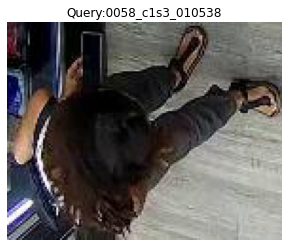

El ID mas repetido es: 0058


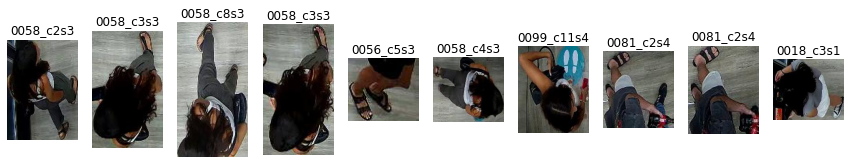

In [144]:
# Correr la busqueda
import random

query_path="./Dataset/output_resnet_256x196_q" # output_resnet50_market1501_aug_q
num_q=get_json_len(query_path) # nro. de queries
numero_aleatorio = random.randint(0, num_q)
print("Query:", numero_aleatorio)

query=get_embedding_for_json(query_path, numero_aleatorio)
# Correr la busqueda
res=run_search_all(query)
# Obtener los campos de las devoluciones de la busqueda
image_paths = [hit.entity.get('img_path') for hit in res[0][:]]
person_id = [hit.entity.get('person_id') for hit in res[0][:]]
scores_l2 = [hit.distance for hit in res[0][:]]
print(scores_l2)
print(person_id)
# Mostrar las imágenes utilizando Matplotlib
show_images(query["img_path"])
show_images(image_paths, person_id)

In [82]:
collection.release()

# Evaluar las busquedas

In [145]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_cmc(id_queries, id_first_10_matchs):
    cmc_ranks = [0] * 10
    total_queries = len(id_queries)
    cmc_values = []

    for i in range(total_queries):
        query = id_queries[i]
        matches = id_first_10_matchs[i]

        # Check if query is in top 1, 5, 10
        for j in range(10):
            if query in matches[:j+1]:
                cmc_ranks[j] += 1

        # Calculate CMC curve
        cmc_values.append([sum(query in matches[:j+1] for j in range(1, len(matches)+1)) / len(matches)])

    cmc_ranks = [cmc_rank / total_queries for cmc_rank in cmc_ranks]
    return cmc_ranks, cmc_values

def calculate_mAP(id_queries, id_first_10_matchs):
    average_precisions = []
    total_queries = len(id_queries)
    
    for i in range(total_queries):
        query = id_queries[i]
        matches = id_first_10_matchs[i]
        # print(query, matches)
        precision_sum = 0
        #relevant_matches = 0
        for j, match in enumerate(matches):
            relevant_count = matches[:j+1].count(query)
            #if match == query:
            #relevant_matches += 1
            precision_sum += relevant_count / (j + 1)
            #print(i, query,match, relevant_count / (j + 1))

        average_precision = precision_sum / len(matches)
        # print(average_precision)
        average_precisions.append(average_precision)

    mAP = np.mean(average_precisions)
    return mAP

def plot_cmc(cmc_ranks, cmc_values):
    ranks = list(range(1, 11))
    plt.plot(ranks, cmc_ranks, marker='o', linestyle='-')
    plt.title('CMC Curve')
    plt.xlabel('Rank')
    plt.ylabel('CMC Value')
    plt.xticks(np.arange(1, 11, step=1))
    plt.grid(True)
    plt.show()

def calculate_and_plot_metrics(id_queries, id_first_10_matchs):
    cmc_ranks, cmc_values = calculate_cmc(id_queries, id_first_10_matchs)
    mAP = calculate_mAP(id_queries, id_first_10_matchs)

    print(f'CMC Ranks 1-10: {cmc_ranks}')
    print(f'mAP: {mAP}')

    plot_cmc(cmc_ranks, cmc_values)



In [146]:
# Correr la busqueda
query_path="./Dataset/output_resnet_256x196_q" # output_resnet50_market1501_aug_q
num_q=get_json_len(query_path) # nro. de queries
id_queries=[]
id_first_10_matchs=[]

# Consultar en la base de datos por cada una de la queries
for i in range(num_q):
    query=get_embedding_for_json(query_path, i)
    query_id,_= extract_id(query['img_path'])
    res=run_search_all(query)
    # image_paths = [hit.entity.get('img_path') for hit in res[0][:]]
    person_id = [hit.entity.get('person_id') for hit in res[0][:]]
    #scores_l2 = [hit.distance for hit in res[0][:]]
    
    id_queries.append(query_id)
    id_first_10_matchs.append(person_id)


CMC Ranks 1-10: [0.7330827067669173, 0.793233082706767, 0.825187969924812, 0.8383458646616542, 0.8646616541353384, 0.8740601503759399, 0.8853383458646616, 0.8947368421052632, 0.9022556390977443, 0.9078947368421053]
mAP: 0.6623995255997136


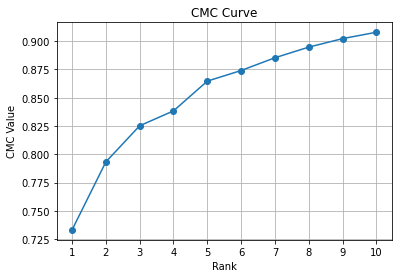

In [147]:
calculate_and_plot_metrics(id_queries, id_first_10_matchs)

## Calcular distancias entre embeddings

In [387]:
import json
import numpy as np
import os

def calculate_embedding_distances(results_1_path, results_path):
    # Leer los archivos JSON y cargar los datos en listas de diccionarios
    with open(results_1_path, 'r') as f:
        results_1 = json.load(f)
    
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    # Inicializar el diccionario de resultados
    embedding_distances = {}
    
    # Iterar sobre los elementos de ambas listas
    for result_1 in results_1:
        for result in results:
            # Obtener los nombres de las imágenes
            img_path_1 = result_1['img_path']
            img_path = os.path.basename(result['img_path'])
            
            # Verificar si los nombres de las imágenes coinciden
            if img_path_1 == img_path:
                # Calcular la distancia euclidiana entre los embeddings
                embedding_1 = np.array(result_1['embedding'])
                embedding = np.array(result['embedding'])
                distance = np.linalg.norm(embedding_1 - embedding)
                
                # Almacenar el resultado en el diccionario
                embedding_distances[img_path_1] = distance
                break  # Salir del bucle interno si se encuentra una coincidencia
    
    return embedding_distances


In [401]:
# Ejemplo de uso
data_path="./Dataset/source00"
results_1_path = os.path.join(data_path, "results_1.json")
print(results_1_path)
results_path = os.path.join(data_path, "results.json")
print(results_path)
embedding_distances = calculate_embedding_distances(results_1_path, results_path)
print(embedding_distances)

./Dataset/source00/results_1.json
./Dataset/source00/results.json
{'0000_c0s1_0000383.jpg': 8.68786298847908, '0000_c0s1_0000385.jpg': 9.051906407472446}
